### 聚类
1、LDA模型聚类  
2、BTM模型聚类  

In [14]:
# 导入依赖（所有依赖）
import os
import pandas as pd
import re
import jieba
import jieba.posseg as psg
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import pyLDAvis
import pyLDAvis.sklearn
from wordcloud import WordCloud
import matplotlib.pyplot as plt


#### 数据导入

In [16]:
# 路径的设置和文件读取
output_path = r'Output'
file_path = r'Data\rawdata_reprocessed.csv'
stop_file = r'Data\stop_words.txt'
jieba.load_userdict(r'Data\userdic.txt')
data = pd.read_csv(file_path).astype(str)
tfidf_data = data.copy()
count_data = data.copy()
data.head()

,weibo_username,weibo_verification,weibo_content,weibo_content_preprocessed,submit_time,forward_counts,comments_counts,points_times
0,辣子鸡谁做的好吃,nan,好像可以在自己幻想的元宇宙里过一辈子好像已经过完了一辈子双鱼座的脑子要不得,好像 幻想 元宇宙 里 一辈子 好像 完 一辈子 双鱼座 脑子 要不得,01月10日 23:59,0,0,0
1,远古的刀,nan,反正闭关锁宇宙我们将会面临下一次的闭关锁国融入不了全球经济王峻涛跟你们讲我相信这个元宇宙真的...,反正 闭关 锁 宇宙 将会 面临 闭关锁国 融入 全球 经济 王峻涛 讲 元宇宙 真的 一下...,01月10日 23:58,32,3,0
2,暮景烟_深浅,nan,周深先生之夜元宇宙周深拥有了生米就像拥有了梦的翅膀卡布叻周深放心飞吧生米永相随时尚先生元宇宙...,周深 之夜 元宇宙 周深 拥有 生米 拥有 梦 翅膀 卡布 叻 周深 放心 飞 生米 永 相...,01月10日 23:58,0,0,0
3,东辉毅恒传媒,nan,王峻涛其实吧你有空可以再看看这个视频跟你们讲我相信这个元宇宙真的会来虽然不是一下子就到来还需...,王峻涛 有空 视频 讲 元宇宙 真的 一下子 到来 技术 突破 社会 讲 玩 后果 人会 分...,01月10日 23:57,0,0,0
4,在寒蝉鸣泣中等待夏日重现,nan,敬元宇宙让基尔希斯坦的女朋友的微博视频,敬 元宇宙 基尔 希斯 坦 女朋友 微博 视频,01月10日 23:57,0,0,5


In [21]:
wl = []
w = psg.cut("好像可以在自己幻想的元宇宙里过一辈子好像已经过完了一辈子双鱼座的脑子要不得")

for i in w:
    print(i)

好像/v
可以/c
在/p
自己/r
幻想/n
的/uj
元宇宙/x
里/f
过/ug
一辈子/m
好像/v
已经/d
过完/v
了/ul
一辈子/m
双鱼座/nz
的/uj
脑子/n
要不得/v


In [6]:
# 中文分词，使用jieba分词，只保留名词/动名词
def chinese_word_cut(mytext):
    try:
        stopword_list = open(stop_file,encoding ='utf-8')
    except:
        stopword_list = []
        print("error in stop_file")
    stop_list = []
    flag_list = ['n','nz','vn']
    for line in stopword_list:
        line = re.sub(u'\n|\\r', '', line)
        stop_list.append(line)
    
    word_list = []
    #jieba分词
    seg_list = jieba.cut(mytext)
    for seg_word in seg_list:
        # 只保留中文
        word = re.sub(u'[^\u4e00-\u9fa5]','',seg_word.word)
        find = 0
        for stop_word in stop_list:
            if stop_word == word or len(word)<2:     #this word is stopword
                    find = 1
                    break
        if find == 0 and seg_word.flag in flag_list:
            word_list.append(word)      
    return (" ").join(word_list)

In [7]:
data["content"] = data.weibo_content.apply(chinese_word_cut)
data.to_csv('weibi_data_keywords.csv')

### LDA分析

In [ ]:
# 定义打印主题词函数
def print_top_words(model, feature_names, n_top_words):
    tword = []
    for topic_idx, topic in enumerate(model.components_):
        # print("Topic #%d:" % topic_idx)
        topic_w = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        tword.append(topic_w)
        print(topic_w)
    return tword
#提取1000个特征词语
n_features = 1000 
# 根据单词出现的次数向量化
count_tf_vectorizer = CountVectorizer(strip_accents = 'unicode',max_features=n_features,stop_words='english',max_df = 0.5,min_df = 10)
# 根据TFIDF算法向量化
tfidf_tf_vectorizer = TfidfVectorizer(strip_accents = 'unicode',max_features=n_features,stop_words='english',max_df = 0.5,min_df = 10)

count_tf = count_tf_vectorizer.fit_transform(data.content)
tfidf_tf = tfidf_tf_vectorizer.fit_transform(data.content)
n_topics = 5

count_lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50,learning_method='batch',learning_offset=50,random_state=0)
tfidf_lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50,learning_method='batch',learning_offset=50,random_state=0)


##### 以下是训练代码，运行时间较久

In [9]:
count_lda.fit(count_tf)
tfidf_lda.fit(tfidf_tf)

LatentDirichletAllocation(learning_offset=50, max_iter=50, n_components=5,
                          random_state=0)

#####  

In [23]:
# 输出每个主题对应词语
n_top_words = 25
count_tf_feature_names = count_tf_vectorizer.get_feature_names()
count_topic_word = print_top_words(count_lda, count_tf_feature_names, n_top_words)

tfidf_tf_feature_names = tfidf_tf_vectorizer.get_feature_names()
tfidf_topic_word = print_top_words(tfidf_lda, tfidf_tf_feature_names, n_top_words)

# 输出每个文本对应的主题
count_topics=count_lda.transform(count_tf)
tfidf_topics=tfidf_lda.transform(tfidf_tf)

count_topic = []
for t in count_topics:
    count_topic.append("Topic #"+str(list(t).index(np.max(t))))
count_data['概率最大的主题序号']=count_topic
count_data['每个主题对应概率']=list(count_topics)
count_data.to_excel(output_path+"data_topic_count.xlsx",index=False)

tfidf_topic = []
for t in tfidf_topics:
    tfidf_topic.append("Topic #"+str(list(t).index(np.max(t))))
tfidf_data['概率最大的主题序号']=tfidf_topic
tfidf_data['每个主题对应概率']=list(tfidf_topics)
tfidf_data.to_excel(output_path+"data_topic_tfidf.xlsx",index=False)

c:\Users\31897\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


世界 宇宙 数字 视频 藏品 人类 现实 平台 生活 抽奖 体验 艺术 话题 时间 虚拟世界 时尚 朋友 空间 感觉 时代 直播 官方 概念 电影 作品
股份 板块 科技 概念 个股 汽车 能源 医药 创业板 龙头 药业 电力 涨幅 指数 煤炭 新能源 化工 股票 医疗 连板 集团 电子 概念股 资金 跌幅
链接 区块 网页 游戏 社区 项目 货币 以太 海盗 视频 币圈 手游 文章 头条 财经 交易 上线 合约 商标 数字 宇宙 链游 生态 投资 代币
公司 技术 发展 数字 科技 游戏 互联网 产品 行业 领域 产业 企业 概念 投资 经济 平台 数据 全球 业务 内容 智能 市场 服务 合作 用户
市场 板块 资金 行情 机会 方向 指数 预期 调整 个股 趋势 股票 大盘 新能源 情绪 走势 行业 题材 热点 龙头 风险 逻辑 股市 重点 影响
世界 人类 现实 感觉 视频 生活 宇宙 体验 时代 虚拟世界 艺术 老师 电影 科技 概念 空间 技术 时间 玩家 科幻 人生 游戏 社会 故事 直播
板块 股份 市场 个股 资金 股票 指数 概念 龙头 行情 机会 新能源 题材 方向 科技 调整 大盘 趋势 汽车 热点 医药 走势 预期 创业板 股市
链接 网页 区块 视频 手游 游戏 项目 以太 社区 币圈 货币 链游 合约 海盗 商标 评论 狗狗 财经 上线 宇宙 币币 交易 生态 代币 女王
宇宙 藏品 数字 抽奖 时尚 平台 回家 话题 星球 官方 文章 音乐 头条 新品 发布会 视频 玩法 图片 朋友 粉丝 偶像 品牌 代言人 专属 版权
公司 概念 技术 发展 游戏 数字 投资 科技 互联网 产品 产业 领域 区块 平台 经济 行业 企业 布局 全球 社交 用户 市场 资本 资产 业务


KeyboardInterrupt: 

#### 可视化

##### 网页版html

In [11]:
pyLDAvis.enable_notebook()
pic = pyLDAvis.sklearn.prepare(count_lda, count_tf, count_tf_vectorizer)
pyLDAvis.display(pic)
pyLDAvis.save_html(pic, output_path+'count_lda_pass'+str(n_topics)+'.html')
pyLDAvis.display(pic)

c:\Users\31897\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\31897\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [12]:
pyLDAvis.enable_notebook()
pic = pyLDAvis.sklearn.prepare(tfidf_lda, tfidf_tf, tfidf_tf_vectorizer)
pyLDAvis.display(pic)
pyLDAvis.save_html(pic, output_path+'tfidf_lda_pass'+str(n_topics)+'.html')
pyLDAvis.display(pic)

c:\Users\31897\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\31897\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


##### 词云图

In [13]:
for i in range(0, n_topics):
    words_frequence = {x[0]:x[1] for x in count_lda.show_topic(i, topn=20)}
    print(words_frequence)
    backgroud_Image=plt.imread('dog.jpg')
    # 若是有中文的话，font_path ='simsun.ttc'必须添加，不然会出现方框，不出现汉字
    # simsun.ttc为汉字编码文件，可以从本地windows系统找一个汉字编码文件上传， 如C:\\Windows\Fonts下有许多汉字编码文件
    wordcloud = WordCloud(font_path ='simsun.ttc',mask=backgroud_Image,repeat=True,background_color='white')
    wordcloud = wordcloud.fit_words(words_frequence)
    plt.imshow(wordcloud)
    plt.show()


AttributeError: 'LatentDirichletAllocation' object has no attribute 'show_topic'

#### 困惑度分析

1
2
3
4


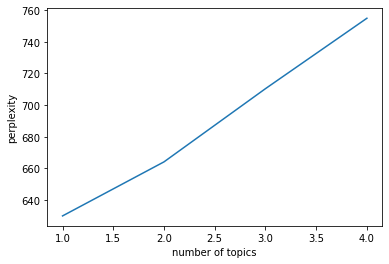

In [27]:
plexs = []
scores = []
n_max_topics = 5
for i in range(1,n_max_topics):
    print(i)
    lda = LatentDirichletAllocation(n_components=i, max_iter=50,learning_method='batch',learning_offset=50,random_state=0)
    lda.fit(tfidf_tf)
    plexs.append(lda.perplexity(tfidf_tf))
    scores.append(lda.score(tfidf_tf))
n_t = 4#区间最右侧的值。注意：不能大于n_max_topics
x=list(range(1,n_t+1))
plt.plot(x,plexs[0:n_t])
plt.xlabel("number of topics")
plt.ylabel("perplexity")
plt.show()

In [28]:
plexs = []
scores = []
n_max_topics = 5
for i in range(1,n_max_topics):
    print(i)
    lda = LatentDirichletAllocation(n_components=i, max_iter=50,learning_method='batch',learning_offset=50,random_state=0)
    lda.fit(count_tf)
    plexs.append(lda.perplexity(count_tf))
    scores.append(lda.score(count_tf))
n_t=4#区间最右侧的值。注意：不能大于n_max_topics
x=list(range(1,n_t+1))
plt.plot(x,plexs[0:n_t])
plt.xlabel("number of topics")
plt.ylabel("perplexity")
plt.show()

1
2


KeyboardInterrupt: 